In [1]:
import Pkg
Pkg.activate("packages")
using CSV, DataFrames, Plots, Plots.PlotMeasures, StatsPlots, Statistics

  Activating environment at `~/Documents/Still evolving/Quantifying-SIM/packages/Project.toml`
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1342
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1342
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1342


### Figure 2: Quantification of the accuray and precision of our inference method using simulated mutant count data

In [3]:
# Reading the (true) input parameters
p = "range_mu-inc"
p2 = "range_switching"
true_para_1 = DataFrame(CSV.File("input_parameters/"*p*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*p2*".csv"))
range_para_1 = collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) ./ true_para_1.divisions_off
range_para_2 = collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1]) ./ true_para_2.divisions_off
J1 = length(range_para_1)
J2 = length(range_para_2)
mu_off_true = true_para_1.mutations_off[1]
mu_on_true = mu_off_true * 10 .^ range_para_1
R = true_para_1.number_fluctuation_assays[1];

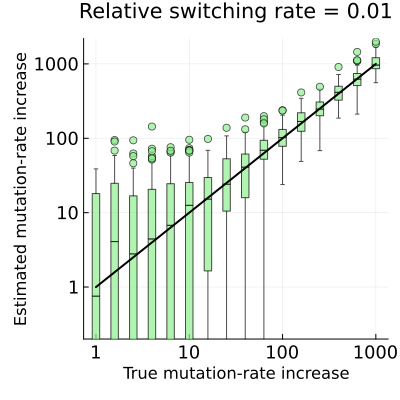

In [4]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Estimated compared to true mutation-rate increase for switching=0.01
m = "het_zero_div"
P_inc = plot(size=(400,400))
r = 11
for j1 = 1:2:J1
    inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$j1.csv"))
    boxplot!(P_inc, [j1], inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)], lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc, xticks=(collect(1:10:J1), Int.(10 .^ range_para_1[1:10:J1])), yticks=(Int.(10 .^ range_para_1[1:10:J1]), Int.(10 .^ range_para_1[1:10:J1])), yscale=:log10, ylim=(0.2, 2200), tickfontsize=12)
plot!(mu_on_true/mu_off_true, c=:black, width=2, lab="")
plot!(ylab="Estimated mutation-rate increase", xlab="True mutation-rate increase", title="Relative switching rate = $(round(10^range_para_2[r], digits=3))")

In [5]:
# Determining numerical values for the precision
i = 21
inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$i.csv"))
println("Mutation-rate increase = ", (10 .^range_para_1)[i])
println("25 and 75 percent quantiles: ", quantile(inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)], [0.25,0.75])/ (10 .^range_para_1)[i])

Mutation-rate increase = 100.0
25 and 75 percent quantiles: [0.7803450056982675, 1.3151145797549182]


In [6]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Relative error and coefficient of variation across the estimates
RE_alpha_mu = Matrix{Float64}(undef, (J2, J1))
CV_alpha_mu = Matrix{Float64}(undef, (J2, J1))
for j2 = 1:J2
    p_folder = "/switch_$j2"
    for j1 = 1:J1
        inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*p_folder*"/"*m*"_$j1.csv"))
        RE_alpha_mu[j2, j1] = (median(inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)]) - mu_on_true[j1]/mu_off_true) / (mu_on_true[j1]/mu_off_true)
        CV_alpha_mu[j2, j1] = std(inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)]) / mean(inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)])
    end
end

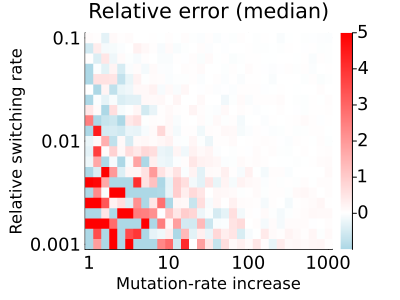

In [7]:
c_max = 5
P_RE = plot(size=(400,300), rightmargin=5mm)
heatmap!(RE_alpha_mu, c=cgrad([:lightblue,:white,:red], [0,-minimum(RE_alpha_mu)/(c_max-minimum(RE_alpha_mu)),1]), clim=(minimum(RE_alpha_mu), c_max))
plot!(xticks=(collect(1:10:J1), Int.(10 .^ range_para_1[1:10:J1])), yticks=(collect(1:10:J2), 10 .^ range_para_2[1:10:J2]), tickfontsize=12)
plot!(title="Relative error (median)", xlab="Mutation-rate increase", ylab="Relative switching rate")

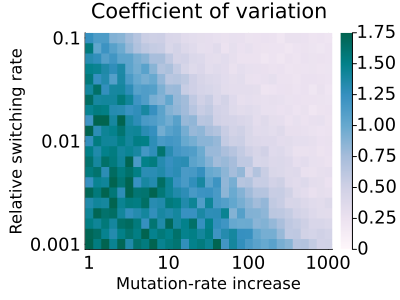

In [8]:
P_CV = plot(size=(400,300), rightmargin=5mm)
heatmap!(CV_alpha_mu, fill=true, levels=8, c=:PuBuGn_8, clim=(0, 1.75))
plot!(xticks=(collect(1:10:J1), Int.(10 .^ range_para_1[1:10:J1])), yticks=(collect(1:10:J2), 10 .^ range_para_2[1:10:J2]), tickfontsize=12)
plot!(title="Coefficient of variation", xlab="Mutation-rate increase", ylab="Relative switching rate")

In [79]:
savefig(P_inc, "figures/Figure_2A.pdf")
savefig(P_RE, "figures/Figure_2B.png")
savefig(P_CV, "figures/Figure_2C.png")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_2C.png"

### Figure 3: Impact of cell death on the estimation of the mutation-rate increase

In [9]:
# Reading the (true) input parameters
p = "range_death-off_switch-5"
p2 = "range_death-on_switch-5"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) ./ true_para.divisions_off
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
R = true_para.number_fluctuation_assays[1];

100

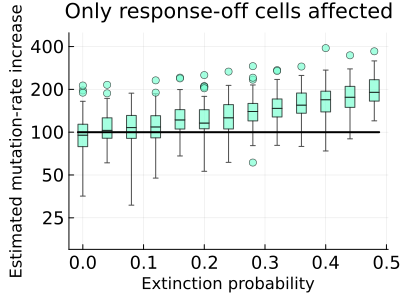

In [10]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-off cells are affected by cell death
m = "het_zero_div"
P_inc_off = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$r/"*m*"_$j.csv"))
    boxplot!(P_inc_off, [j], inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)], lab="", c=:aquamarine, alpha=0.7)
end
plot!(P_inc_off, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
plot!(title="Only response-off cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


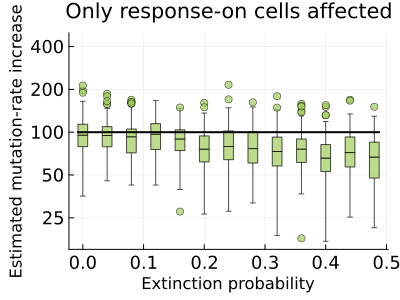

In [11]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-on cells are affected by cell death
m = "het_zero_div"
P_inc_on = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$j/"*m*"_$r.csv"))
    boxplot!(P_inc_on, [j], inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)], lab="", c=:darkolivegreen3, alpha=0.7)
end
plot!(P_inc_on, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
plot!(title="Only response-on cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


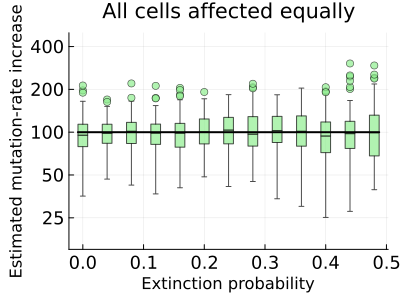

In [12]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# All cells are affected by cell death equally
m = "het_zero_div"
P_inc_all = plot(size=(400,300))
for j = 1:2:J
    inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$j/"*m*"_$j.csv"))
    boxplot!(P_inc_all, [j], inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)], lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_all, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
plot!(title="All cells affected equally", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


In [106]:
savefig(P_inc_off, "figures/Figure_3A.pdf")
savefig(P_inc_on, "figures/Figure_3B.pdf")
savefig(P_inc_all, "figures/Figure_3C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_3C.pdf"

#### Appendix Figure: Impact of differential fitness of mutants

In [20]:
# Reading the (true) input parameters
p = "range_fit-mut"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) ./ true_para.divisions_off
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
R = true_para.number_fluctuation_assays[1];

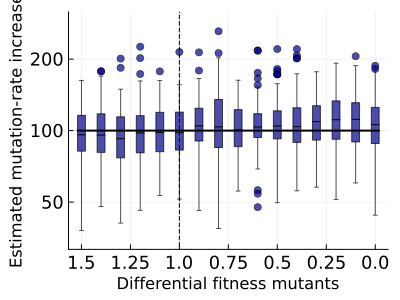

In [38]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
m = "het_zero_div"
P_inc_fit = plot(size=(400,300))
vline!([11], style=:dash, c=:black, lab="")
for j = 1:2:J
    inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv"))
    boxplot!(P_inc_fit, [j], inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)], lab="", c=:darkblue, alpha=0.7)
end
plot!(P_inc_fit, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.5, 10^2.5), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
plot!(xlab="Differential fitness mutants", ylab="Estimated mutation-rate increase")

### Figure 4: Estimation when response-off cells have a non-zero division rate.

In [47]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) ./ true_para.divisions_off
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
R = true_para.number_fluctuation_assays[1];


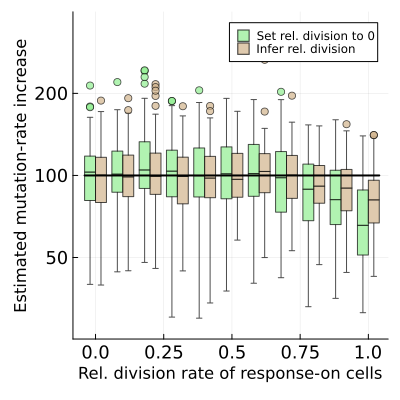

In [62]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# Estimated compared to true mutation-rate increase 
m_1 = "het_zero_div"
m_2 = "het_infer_div"
P_inc_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv"))
    inferred_para_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv"))
    boxplot!(P_inc_div, [j-0.4], inferred_para_1.mutation_rate_on[(inferred_para_1.AIC .!= Inf)] ./ inferred_para_1.mutation_rate_off[(inferred_para_1.AIC .!= Inf)], lab="", c=:lightgreen, alpha=0.7, boxwidth=0.4)
    boxplot!(P_inc_div, [j+0.4], inferred_para_2.mutation_rate_on[(inferred_para_2.AIC .!= Inf)] ./ inferred_para_2.mutation_rate_off[(inferred_para_2.AIC .!= Inf)], lab="", c=:tan, alpha=0.7, boxwidth=0.4)
end
plot!(P_inc_div, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
scatter!([0], [1], lab="Set rel. division to 0", c=:lightgreen, alpha=0.7, marker=:square)
scatter!([0], [1], lab="Infer rel. division", c=:tan, alpha=0.7, marker=:square)

In [ ]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# Estimated compared to true rel. division rate of response-on cells
m_1 = "het_zero_div"
m_2 = "het_infer_div"
P_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv"))
    inferred_para_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv"))
    boxplot!(P_div, [j-0.4], inferred_para_1.mutation_rate_on[(inferred_para_1.AIC .!= Inf)] ./ inferred_para_1.mutation_rate_off[(inferred_para_1.AIC .!= Inf)], lab="", c=:lightgreen, alpha=0.7, boxwidth=0.4)
    boxplot!(P_div, [j+0.4], inferred_para_2.mutation_rate_on[(inferred_para_2.AIC .!= Inf)] ./ inferred_para_2.mutation_rate_off[(inferred_para_2.AIC .!= Inf)], lab="", c=:tan, alpha=0.7, boxwidth=0.4)
end
plot!(P_inc_div, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")